In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Any results you write to the current directory are saved as output.
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

import glob
from platform import python_version
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt

In [3]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.1.3
torch==1.13.0+cu117
matplotlib==3.6.2


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
#load data
data = pd.read_csv("..\..\Data\Day\S&P 500 Historical Data00-20.csv")

In [6]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [7]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [8]:
data.index = data.index[::-1]

In [10]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [11]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [12]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [13]:
#change indexes
special_data = special_data.rename(columns={'Date': 'timestamp'})
special_data.set_index('timestamp', inplace=True)

In [14]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

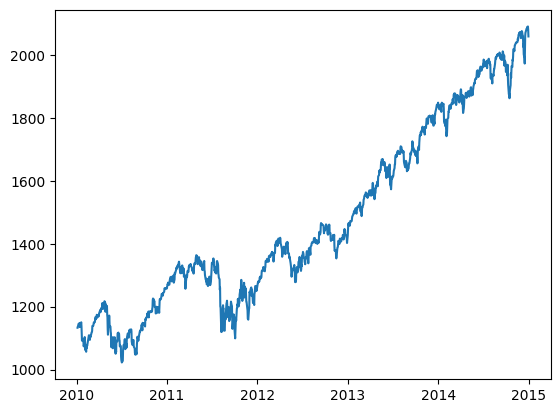

In [15]:
plt.plot(special_data)

In [16]:
data_len = len(special_data)
train_len = data_len * 0.7
test_len = data_len * 0.15
val_len = data_len - train_len - test_len

train_data = special_data[:int(train_len)]
test_data = special_data[int(train_len):int(train_len + test_len)]
real_val = special_data[-int(val_len):]
val_data = real_val[:int(8)]

In [17]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
n_steps = 3
train_x, train_y = split_sequence(train_data.Price.values, n_steps)
test_x, test_y = split_sequence(test_data.Price.values, n_steps)
val_x, val_y = split_sequence(val_data.Price.values, n_steps)

In [18]:
class PriceDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        return item, label

In [19]:
batch_size = 5

train = PriceDataset(train_x.reshape(train_x.shape[0], train_x.shape[1], 1), train_y)
test = PriceDataset(test_x.reshape(test_x.shape[0], test_x.shape[1], 1), test_y)
val = PriceDataset(val_x.reshape(val_x.shape[0], val_x.shape[1], 1), val_y)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)

In [20]:
class CNN_ForecastNet(nn.Module):
    def __init__(self, batch_size):
        super(CNN_ForecastNet, self).__init__()
        self.conv1d = nn.Conv1d(3, 64, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64 * batch_size, 50)
        self.fc2 = nn.Linear(50, 1)
        self.double()
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [21]:
model = CNN_ForecastNet(batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.MSELoss()

train_losses = []
test_losses = []

epochs = 200
for epoch in range(epochs):
    if epoch % 10 != 0:
        print('Epoch [{}/{}]'.format(epoch + 1, epochs))
    running_loss = .0
    model.train()
    for idx, ( inputs,labels) in enumerate(train_loader):
        if(inputs.shape[0] != batch_size):
            continue
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.double())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss 
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())

    running_loss = .0
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            if(inputs.shape[0] != batch_size):
                continue
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.double())
            loss = criterion(preds,labels)
            running_loss += loss  
        test_loss = running_loss / len(test_loader)
        test_losses.append(test_loss.detach().cpu().numpy())
    # print progress
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, test Loss: {:.4f}'.format(
            epoch+1, epochs, train_losses[-1], test_losses[-1]))
    gc.collect()

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/200], Train Loss: 1800591.2964, test Loss: 2603509.4219
Epoch [2/200]
Epoch [3/200]
Epoch [4/200]
Epoch [5/200]
Epoch [6/200]
Epoch [7/200]
Epoch [8/200]
Epoch [9/200]
Epoch [10/200]
Epoch [11/200], Train Loss: 14895.8236, test Loss: 16840.0760
Epoch [12/200]
Epoch [13/200]
Epoch [14/200]
Epoch [15/200]
Epoch [16/200]
Epoch [17/200]
Epoch [18/200]
Epoch [19/200]
Epoch [20/200]
Epoch [21/200], Train Loss: 260.9200, test Loss: 207.5088
Epoch [22/200]
Epoch [23/200]
Epoch [24/200]
Epoch [25/200]
Epoch [26/200]
Epoch [27/200]
Epoch [28/200]
Epoch [29/200]
Epoch [30/200]
Epoch [31/200], Train Loss: 261.2999, test Loss: 206.6875
Epoch [32/200]
Epoch [33/200]
Epoch [34/200]
Epoch [35/200]
Epoch [36/200]
Epoch [37/200]
Epoch [38/200]
Epoch [39/200]
Epoch [40/200]
Epoch [41/200], Train Loss: 259.0260, test Loss: 204.1288
Epoch [42/200]
Epoch [43/200]
Epoch [44/200]
Epoch [45/200]
Epoch [46/200]
Epoch [47/200]
Epoch [48/200]
Epoch [49/200]
Epoch [50/200]
Epoch [51/200], Train Loss: 260.

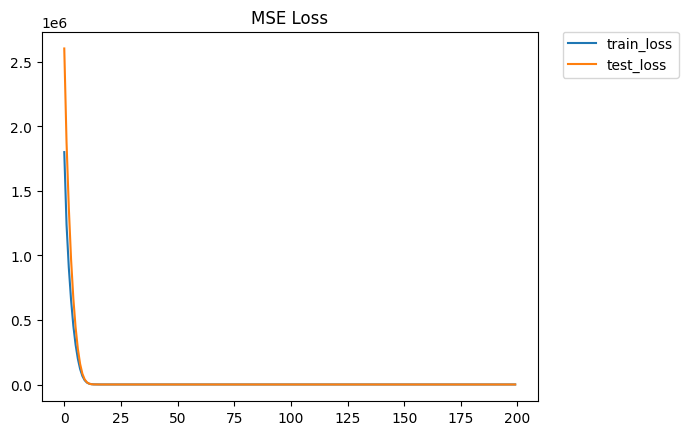

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='test_loss')
plt.title('MSE Loss')
#plt.ylim(0, 100)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', borderaxespad=0.)

In [23]:
target_x , target_y = split_sequence(val_data.Price, n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

model.eval()
prediction = []
iterations =  int(inputs.shape[0] / batch_size)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size * i:batch_size*(i + 1)]).to(device))
    prediction.append(preds.detach().cpu().numpy())

target_x , target_y = split_sequence(test_data.Price, n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

model.eval()
test_pred = []
iterations =  int(inputs.shape[0] / batch_size)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size * i : batch_size*(i + 1)]).to(device))
    test_pred.append(preds.detach().cpu().numpy())

In [68]:
model.eval()
prediction = []
real_pred = []
begin_val_size = 8
val_data = real_val[:int(begin_val_size)]
temp_frame = real_val[0:1]
if True:
    for j in range(real_val.shape[0] - begin_val_size):
        target_x , target_y = split_sequence(val_data.Price, n_steps)
        inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)
        iterations =  int(inputs.shape[0] / batch_size)
        for i in range(iterations):
            preds = model(torch.tensor(inputs[batch_size * i:batch_size*(i + 1)]).to(device))
            prediction.append(preds.detach().cpu().numpy())
        real_pred.append(prediction[len(prediction) - 1])
        if begin_val_size + j < real_val.shape[0]:
            val_data.loc[real_val.index[begin_val_size + j]] = prediction[len(prediction) - 1]
            temp_frame.loc[val_data.index[0]] = val_data.loc[val_data.index[0]]
            if (val_data.shape[0] - begin_val_size) % 5 != 0: 
                val_data = val_data.drop(real_val.index[j])
            if(temp_frame.shape[0] % 5 == 0):
                val_data = pd.concat([temp_frame, val_data])
                temp_frame = pd.DataFrame()
                temp_frame = val_data[0:1]
        else:
            val_data.loc[val_data.index[val_data.shape[0] - 1] + pd.tseries.offsets.BDay(1)] = prediction[len(prediction) - 1]

C:\Users\Skiv2\AppData\Local\Temp\ipykernel_3716\646594215.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data.loc[real_val.index[begin_val_size + j]] = prediction[len(prediction) - 1]
C:\Users\Skiv2\AppData\Local\Temp\ipykernel_3716\646594215.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_frame.loc[val_data.index[0]] = val_data.loc[val_data.index[0]]
C:\Users\Skiv2\AppData\Local\Temp\ipykernel_3716\646594215.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [66]:
len(val_data)

13

In [62]:
len(real_pred)

180

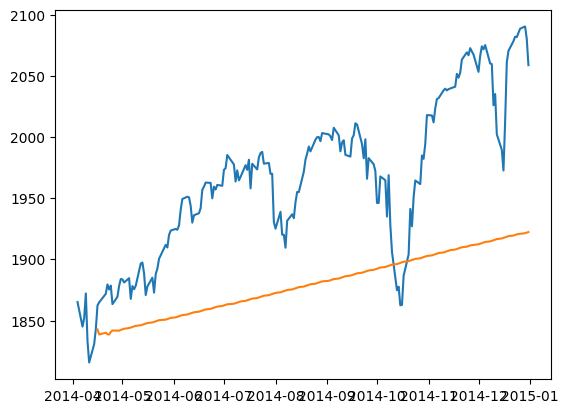

In [69]:
plt.plot(real_val)
plt.plot(real_val.index[8:], real_pred)

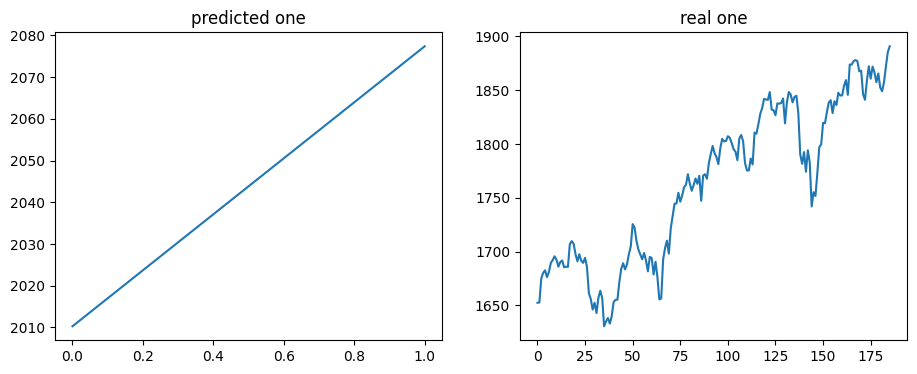

In [102]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (2,) and (37, 1)

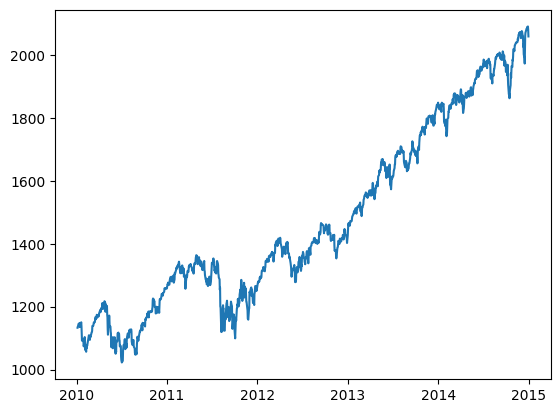

In [116]:
import matplotlib.pyplot as plt

# plot 1
plt.plot(special_data, label = 'True Data')
plt.plot(special_data.index[-len(prediction) - len(val_data): - len(val_data)], test_pred, label = 'Test predicted Data')
plt.plot(special_data.index[-len(prediction):], prediction, label = 'Val predicted Data')
plt.axvline(x = special_data.index[-len(prediction) - len(val_data)], c = 'r', linestyle = '--')
plt.legend()
plt.show()
# plot 2
plt.plot(special_data.index[-len(test_pred)- len(val_data):], special_data.Price[-len(test_pred)- val_len:], label='True Data')
plt.plot(special_data.index[-len(test_pred)- len(val_data): - len(val_data)], test_pred, label='Test predicted Data')
plt.plot(special_data.index[-len(test_pred):], test_pred, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(test_pred) - len(val_data)], c='r', linestyle='--')
plt.legend()
plt.show()